# Exploritory data Analysis to determine potentional model features
Install the snowflake-connector-python if needed

In [1]:
import pandas as pd
import numpy as np
import snowflake.connector
import os
from datetime import datetime
from dotenv import load_dotenv
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LassoCV, LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer, mean_squared_error
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsRegressor
import altair as alt
from sklearn.feature_extraction.text import CountVectorizer

# enable pandas to display up to 500 columns
pd.set_option('display.max_columns', 500)

import sys
import os

# Get the current working directory
current_directory = os.getcwd()

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(current_directory, '..')))

# Import the helper_functions module
from helper_functions import connect_to_snowflake, get_data, write_to_snowflake

## 1.1 Import Data
#### 1.1 Connect to Snowflake using schema ODS

In [2]:
conn = connect_to_snowflake(schema_name='ODS')

Successfully connected to Snowflake schema ODS


## 2. Fetch data from Snowflake

#### Get sample of data from chicago market

In [5]:
sql_query = '''
select * from listings
where market = 'chicago'
 '''

df = get_data(sql_query, conn)
df.shape

(7707, 68)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7707 entries, 0 to 7706
Data columns (total 68 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            7707 non-null   int64  
 1   scrape_id                                     7707 non-null   int64  
 2   last_scraped                                  7707 non-null   object 
 3   name                                          7707 non-null   object 
 4   description                                   7622 non-null   object 
 5   neighborhood_overview                         5428 non-null   object 
 6   host_id                                       7707 non-null   int32  
 7   host_name                                     7707 non-null   object 
 8   host_since                                    7707 non-null   object 
 9   host_location                                 6288 non-null   o

In [29]:
#features:
# host response rate, host acceptance rate
# host is superhost neighborhood_cleansed, host has profile picture, host identity verified, room type, accommodates, bathrooms, beds, review_scores_rating, instant_bookable, market
#predict price
# Convert 'datetime.date' columns to 'datetime64'
date_cols = ['last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review']
features = ['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'neighbourhood_cleansed', 'host_has_profile_pic', 'host_identity_verified', 'room_type', 'accommodates', 'bathrooms', 'beds', 'review_scores_rating', 'instant_bookable', 'market']
cols_to_encode = ['market', 'room_type', 'instant_bookable',  'neighbourhood_cleansed', 'host_has_profile_pic', 'host_identity_verified']
target = 'price'

df_no_dt = df.drop(columns=date_cols)
# Create the ColumnTransformer with OneHotEncoder
# Create the encoder
encoder = OneHotEncoder(sparse=False, dtype=np.int8)

# Create a column transformer
ct = ColumnTransformer(transformers=[('encoder', encoder, cols_to_encode)], remainder='passthrough')

# Fit and transform the data
df_encoded = ct.fit_transform(df_no_dt)

# Get the feature names from the encoder
feature_names = ct.named_transformers_['encoder'].get_feature_names(input_features=cols_to_encode)

# Get the remaining column names from the original DataFrame
remaining_cols = [col for col in df_no_dt.columns if col not in cols_to_encode]

# Combine the encoded feature names with the remaining column names
all_cols = list(feature_names) + remaining_cols

# Convert the numpy array to a DataFrame
df_encoded = pd.DataFrame(df_encoded, columns=all_cols)
# Select only the object columns
df_objects = df_encoded.select_dtypes(include=['object'])

# Convert all object columns to numeric
df_encoded[df_objects.columns] = df_objects.apply(pd.to_numeric, errors='coerce')

/Users/samkobrin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
# create model columns
model_cols = [col for col in df_no_dt.columns if col not in cols_to_encode]

# Combine the encoded feature names with the remaining column names
all_cols = list(feature_names) + list(["price", "bathrooms", "beds", "accommodates", "host_response_rate", "host_acceptance_rate"])

#select relivant columns
df_encoded = df_encoded[all_cols]

# Fill NA values with the column mean
df_encoded = df_encoded.fillna(df_encoded.mean())

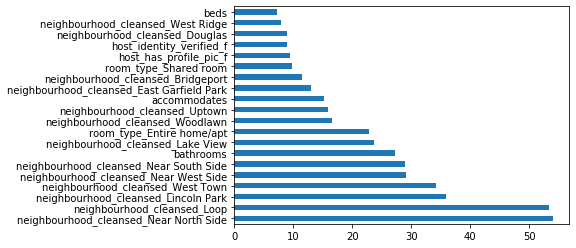

In [31]:
# Define the target variable and the feature matrix
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LassoCV model
lasso = LassoCV(cv=5)

# Fit the model
lasso.fit(X_train, y_train)

# Get the feature importance
importance = pd.Series(abs(lasso.coef_), index = X.columns)

# Plot the feature importance
importance.nlargest(20).plot(kind='barh')

# Display the plot

plt.show()


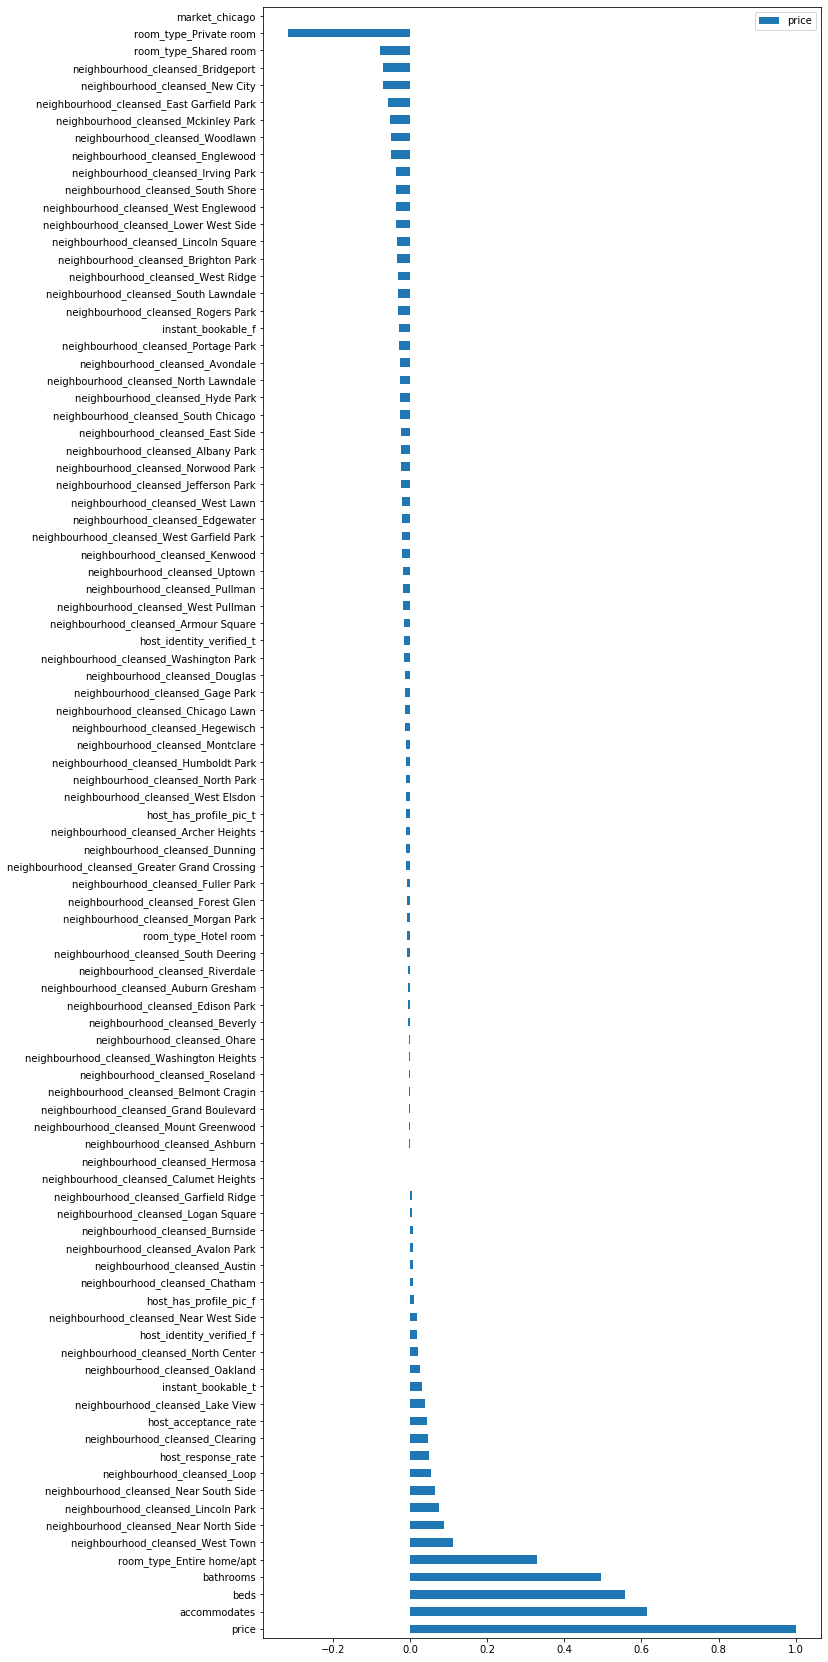

In [32]:
# Calculate correlations
corr = df_encoded.corr()

# determine corrilation with the target variable, price
corr_price = pd.DataFrame(corr['price'].sort_values(ascending=False))
corr_price.plot(kind='barh', figsize=(10, 30))

Based off of these corrlations. It seems that the number of guests a airbnb accomidates, the number of beds, and number of bathrooms are strongly correlated with price. The room type is also a important feature. 

Being instant bookable is not strongly correlated with price, so this is a good feature to drop. We may consider dropping if the host has a profile picture and if there identify is verified. Another consideration is using lat/long instead of neighborhood names to reduce the number of features.

fold results: [9.62840322 9.64000136 9.68303849 9.89456862 9.418402  ]
Root mean squared error: 9.652882738726994
Standard deviation: 0.15170222767081093


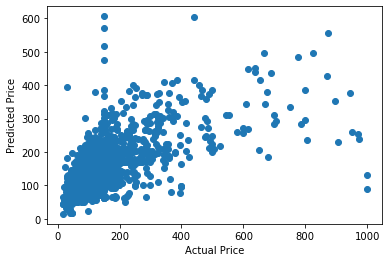

In [33]:
# Drop columns that begin with 'neighborhood_clean'
df_encoded = df_encoded.drop(df_encoded.filter(like='neighbourhood_cleansed').columns, axis=1)
# Drop columns that end with '_f' which are the second half of the one-hot encoded columns
df_encoded = df_encoded.drop(df_encoded.filter(like='_f').columns, axis=1)
# Define the target variable and the feature matrix
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
lr = LinearRegression() 
# Define RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
# Perform 5-fold cross validation with RMSE
scores = cross_val_score(lr, X, y, cv=5, scoring=rmse_scorer)
rmse_cv = np.sqrt(abs(scores))
print(f"fold results: {rmse_cv}")
print(f"Root mean squared error: {rmse_cv.mean()}")
print(f"Standard deviation: {rmse_cv.std()}")
# Fit the model
lr.fit(X_train, y_train)
#make predictions
y_pred = lr.predict(X_test)
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#plot the results
plt.scatter(y_test, y_pred)
# Add labels
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Display the plot
plt.show()

fold results: [9.8384205  9.60076109 9.89607202 9.8826607  9.4156978 ]
Root mean squared error: 9.726722422076303
Standard deviation: 0.1887194048066758


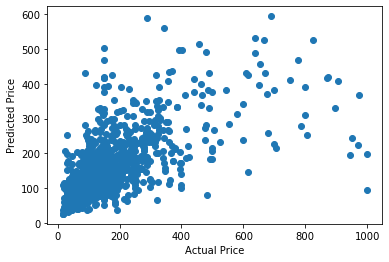

In [34]:
# Create a KNN model
knn = KNeighborsRegressor(n_neighbors=10)

# Perform 5-fold cross validation with RMSE
scores = cross_val_score(knn, X, y, cv=5, scoring=rmse_scorer)
rmse_cv = np.sqrt(abs(scores))
print(f"fold results: {rmse_cv}")
print(f"Root mean squared error: {rmse_cv.mean()}")
print(f"Standard deviation: {rmse_cv.std()}")

# Fit the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Plot the results
plt.scatter(y_test, y_pred)

# Add labels
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Display the plot
plt.show()

In [35]:
# Calculate the absolute differences
differences = np.abs(y_test - y_pred)

# Sort the differences in descending order and select the top 50
top_50_differences = differences.sort_values(ascending=False)[:50]

# Join the top 50 differences with their corresponding features
top_50_with_features = X_test.join(top_50_differences)

# Drop rows with NaN (these are the ones not in the top 50)
top_50_with_features = top_50_with_features.dropna()

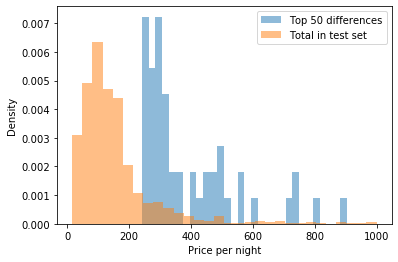

In [36]:
# Create a histogram of the price per night of the top 50 differences
plt.hist(top_50_with_features['price'], bins=30, alpha=0.5, label='Top 50 differences', density=True)

# Create a histogram of the price per night of the total in the test set
plt.hist(y_test, bins=30, alpha=0.5, label='Total in test set', density=True)

# Add labels and legend
plt.xlabel('Price per night')
plt.ylabel('Density')
plt.legend(loc='upper right')

# Display the plot
plt.show()

###  Error Analysis:
 It is evident that the model has the most trouble predicting the prices of high-priced Airbnbs. The significant differences between the actual and predicted prices in the higher price ranges suggest that the model struggles with accurately capturing the patterns associated with more expensive listings.

## Remove more features to simply the model

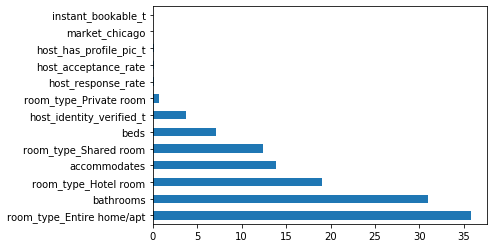

In [37]:
# Create a LassoCV model
lasso = LassoCV(cv=5)

# Fit the model
lasso.fit(X_train, y_train)

# Get the feature importance
importance = pd.Series(abs(lasso.coef_), index = X.columns)

# Plot the feature importance
importance.nlargest(20).plot(kind='barh')

# Display the plot

plt.show()

### Feature Importance Analysis Using Lasso Regression

Lasso feature selection has revealed that certain features in our Airbnb price prediction model for Chicago are less significant. Notably, being instant bookable and having a profile picture do not significantly impact listing prices. This challenges the common belief that instant bookable listings are more expensive. Additionally, host acceptance rate and host response rate were found to have minimal influence on price.

To simplify the model and enhance performance, I will drop the following features: `instant_bookable`, `host_acceptance_rate`, `host_has_profile_pic`, and `host_response_rate`. This streamlined approach will reduce model complexity and focus on the most impactful variables, potentially improving accuracy and generalization.

fold results: [9.6066849  9.64020847 9.67218327 9.88970662 9.41116615]
Root mean squared error: 9.64398988171076
Standard deviation: 0.15282960169632867
number of features: 9


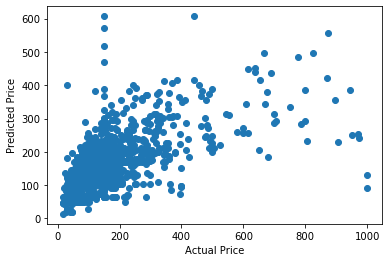

In [38]:
# refit our best model with the more limited set of features

# Drop columns that begin with 'neighborhood_clean'
df_encoded = df_encoded.drop(['instant_bookable_t', 'host_has_profile_pic_t', 'host_acceptance_rate', 'host_response_rate'], axis=1)
# Drop columns that end with '_f' which are the second half of the one-hot encoded columns


# Define the target variable and the feature matrix
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
lr = LinearRegression() 
# Define RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
# Perform 5-fold cross validation with RMSE
scores = cross_val_score(lr, X, y, cv=5, scoring=rmse_scorer)
rmse_cv = np.sqrt(abs(scores))
print(f"fold results: {rmse_cv}")
print(f"Root mean squared error: {rmse_cv.mean()}")
print(f"Standard deviation: {rmse_cv.std()}")
print(f"number of features: {len(X.columns)}")
# Fit the model
lr.fit(X_train, y_train)
#make predictions
y_pred = lr.predict(X_test)
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#plot the results
plt.scatter(y_test, y_pred)
# Add labels
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Display the plot
plt.show()


These metrics indicate that the model's performance remains stable after feature removal. The RMSE and standard deviation suggest that simplifying the model did not negatively impact its accuracy or consistency. This streamlined model is now more efficient, focusing on the most impactful variables.

# Investigate Amenities
Amenities are an important consideration when booking an Airbnb. Therefore, we dedicated time to investigating the relationship between amenities and listing price to determine which amenities add value for Airbnb guests.

In [7]:
date_cols = ['last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review']

sql_query = '''
select * from listings
where market = 'los-angeles'
 '''

df_raw = get_data(sql_query, conn, date_columns=date_cols)
df_raw.shape

(45570, 68)

In [40]:
df = df_raw.copy()

In [42]:
df.amenities = df.amenities.str.replace('[{}"]', '')
df.amenities.head()

/var/folders/d2/h8ktp_td3h1dv5llms3y8d7c0000gn/T/ipykernel_68682/220476170.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df.amenities = df.amenities.str.replace('[{}"]', '')


0    Hot tub, Kitchen, Wifi, Smoke alarm, Free park...
1    Dining table, Cleaning products, Cooking basic...
2    Fire extinguisher, Dedicated workspace, Wifi, ...
3    Hot tub, Fire extinguisher, Dedicated workspac...
4    Self check-in, Cleaning products, First aid ki...
Name: amenities, dtype: object

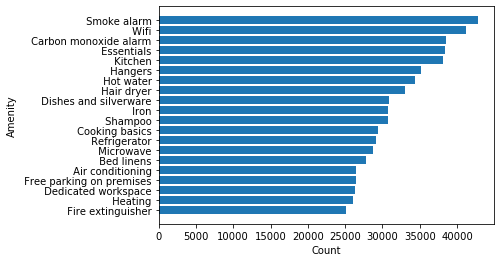

In [43]:
# Split amenities and get value counts
amenities_counts = df['amenities'].str.split(',').explode().value_counts()

# Convert to DataFrame
amenities_df = pd.DataFrame({'Amenity': amenities_counts.index, 'Count': amenities_counts.values})
# Select the top 20 amenities
top_20_amenities = amenities_df.head(20)
# Create a horizontal bar chart with matplotlib
plt.barh(top_20_amenities['Amenity'], top_20_amenities['Count'])

# Invert the y-axis to have the amenity with the highest count at the top
plt.gca().invert_yaxis()

# Add labels
plt.xlabel('Count')
plt.ylabel('Amenity')

# Display the plot
plt.show()

Most of these ameties do not look very indicative of price. Let's expand our search to the top 50 amenities.

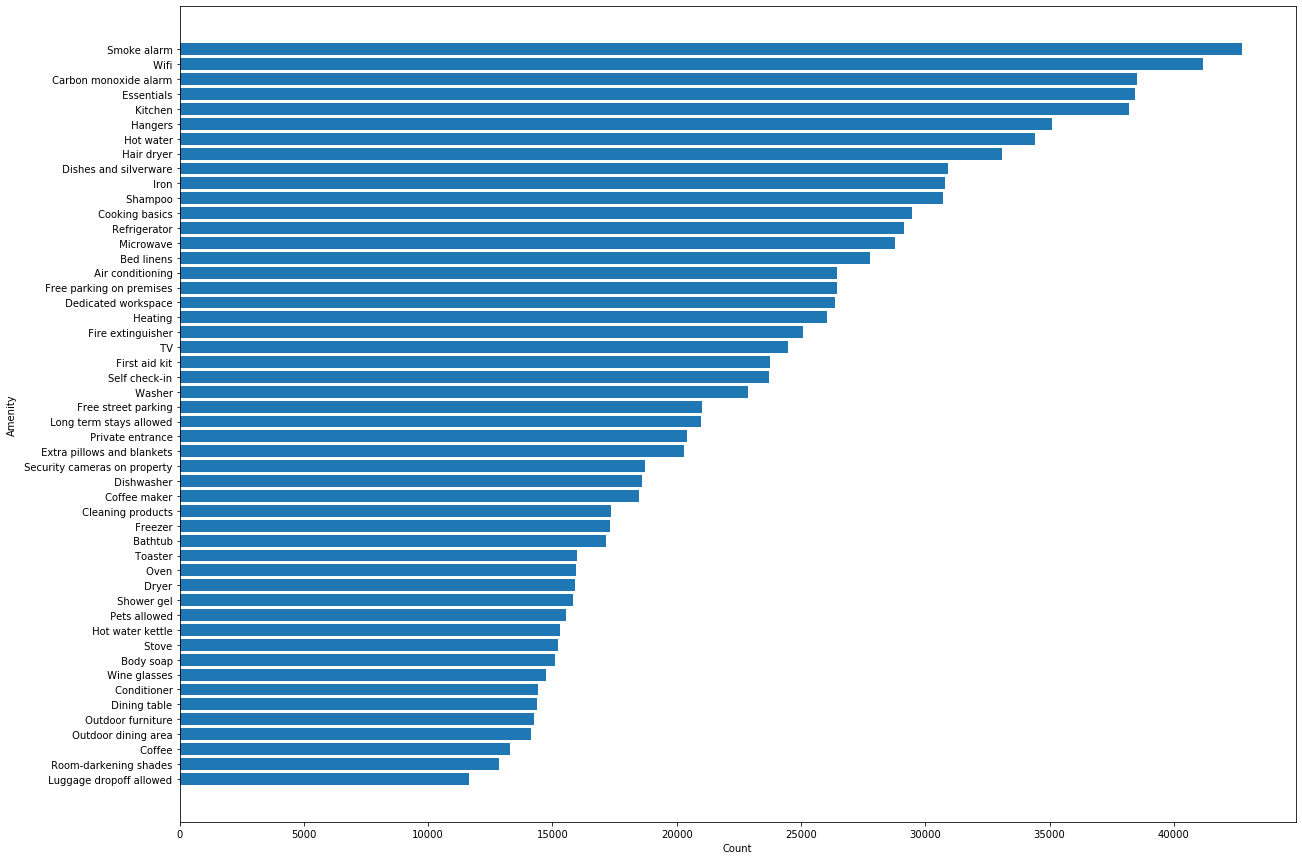

In [44]:
# Select the top 50 amenities
top_50_amenities = amenities_df.head(50)
# Create a horizontal bar chart with matplotlib
plt.figure(figsize=(20, 15))
plt.barh(top_50_amenities['Amenity'], top_50_amenities['Count'])

# Invert the y-axis to have the amenity with the highest count at the top
plt.gca().invert_yaxis()

# Add labels
plt.xlabel('Count')
plt.ylabel('Amenity')

# Display the plot
plt.show()

In [45]:
#now exampine the importance of each of these amenities by fitting a lasso model to the amenities data
# Drop rows with NaN values in the 'amenities' column
df = df.dropna(subset=['amenities', 'price'])
# Split the amenities and transform them into a binary matrix
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(','), min_df=5)
amenities_matrix = vectorizer.fit_transform(df['amenities'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(amenities_matrix, df['price'], test_size=0.2, random_state=42)

# Create and fit a Lasso model
lasso = Lasso()
lasso.fit(X_train, y_train)

# Make predictions
y_pred = lasso.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Get feature importances
importances = lasso.coef_

# Create a DataFrame of feature names and importances
importances_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values('importance', ascending=False)

# Print the DataFrame
print(importances_df.head(100))

Root Mean Squared Error: 133.14947538240335
                    feature  importance
930              ocean view   73.275703
1057           private pool   73.130094
1044        private hot tub   63.749433
810        indoor fireplace   59.796925
367              dishwasher   46.288808
...                     ...         ...
939    or similar body soap    0.000000
938     open specific hours   -0.000000
936           olympic-sized   -0.000000
935            olay shampoo    0.000000
934        olay conditioner    0.000000

[100 rows x 2 columns]
